<a href="https://colab.research.google.com/github/pelinsuciftcioglu/VAE/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Auto-Encoder (VAE)**

VAE implementation inspired by:
- [Tomczak, J. M. (2021). Introduction to Deep Generative Modeling.](https://https://github.com/jmtomczak/intro_dgm)
- [CreativeAI: Deep Learning for Graphics Tutorial Code
](https://github.com/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb)





In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import os

use_gpu = True

In [25]:
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-5

# DISTRBUTION FOR THE DATA (INPUT)

def log_categorical(x, x_new, num_classes, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(x_new, EPS, 1. - EPS))
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

def log_bernoulli(x, x_new, reduction=None, dim=None):
    x_new = torch.clamp(x_new, EPS, 1. - EPS)
    log_p = x * torch.log(x_new) + (1. - x) * torch.log(1. - x_new)
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

# DISTRIBUTION FOR THE VARIATIONAL INFERENCE
def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


# PRIOR DISTRIBUTIONS for p(z)

def log_standard_normal(x, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * x**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

In [26]:
class Encoder(nn.Module):
    def __init__(self, D, H, L):
        super(Encoder, self).__init__()

        self.encoder_net = nn.Sequential(nn.Linear(D, H), nn.LeakyReLU(), nn.Linear(H, 2*L))

    def encode(self, x):
      mu, log_var = self.forward(x)
      return mu, log_var

    def forward(self, x):
      h = self.encoder_net(x)
      mu, log_var =  torch.chunk(h, 2, dim=1)

      return mu, log_var

    def sample(self, mu, log_var):
      std = torch.exp(0.5 * log_var)
      # Sample epsilon ~ N(0,I)
      eps = torch.randn_like(std)
      # Reparameterization trick
      z = mu + eps * std

      return z

    def log_prob(self, mu, log_var, z):
      return log_normal_diag(z, mu, log_var)



In [27]:
class Decoder(nn.Module):
    def __init__(self, D, H, L, distribution, num_vals):
        super(Decoder, self).__init__()
        self.D = D
        self.distribution = distribution
        self.num_vals = num_vals

        self.decoder_net = nn.Sequential(nn.Linear(L, H), nn.LeakyReLU(),
                                         nn.Linear(H, D * num_vals))

    def decode(self, z):
      x_new = self.forward(z)

      return x_new

    def forward(self, z):
      x_new = self.decoder_net(z)
      
      if self.distribution == 'categorical':
        b = x_new.shape[0]
        d = self.D
        x_new = x_new.reshape(b, d, self.num_vals)
        return torch.softmax(x_new, 2)
      
      elif self.distribution == 'bernoulli':
        return torch.sigmoid(x_new)

In [28]:
class Prior(nn.Module):
    def __init__(self, L, prior_distribution):
        super(Prior, self).__init__()
        self.L = L
        self.distribution = prior_distribution

    # def sample(self, batch_size):
    #     z = torch.randn((batch_size, self.L))
    #     return z

    def log_prob(self, z):
      if (self.distribution == 'standard normal'):
        return log_standard_normal(z)

      # elif self.distribution == ''
        # return log____(z)

In [29]:
class VAE(nn.Module):
  def __init__(self, D, H, L, distribution, num_vals, prior_distribution): # Initializations should be added!!!!
        super(VAE, self).__init__()
        self.encoder = Encoder(D, H, L)
        self.decoder = Decoder(D, H, L, distribution, num_vals)
        self.prior = Prior(L, prior_distribution)


        self.num_vals = num_vals
        self.distribution = distribution
  
  def forward(self, x, reduction='avg'):
        x = torch.flatten(x, start_dim=1)

        mu, log_var = self.encoder.encode(x)
        z = self.encoder.sample(mu, log_var)

        ELBO = self.loss(x, z, mu, log_var, reduction)

        return ELBO
  
  def loss(self, x, z, mu, log_var, reduction='avg'):
    # Reconstruction Error
    RE = self.log_prob(x, z)

    # KL-Divergence
    KL = (self.prior.log_prob(z) - self.encoder.log_prob(mu, log_var, z)).sum(-1)

    if reduction == 'sum':
      return -(RE + KL).sum()
    else:
      return -(RE + KL).mean()


  def log_prob(self, x, z):
    x_new = self.decoder.decode(z)

    if self.distribution == 'categorical':
      log_prob = log_categorical(x, x_new, self.num_vals, reduction='sum', dim=-1).sum(-1)
            
    elif self.distribution == 'bernoulli':
      log_prob = log_bernoulli(x, x_new, reduction='sum', dim=-1)

    return log_prob


http://yann.lecun.com/exdb/mnist/

In [30]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

#test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
#test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [31]:
likelihood_type = 'categorical'

if likelihood_type == 'categorical':
    num_vals = 256
elif likelihood_type == 'bernoulli':
    num_vals = 1

prior_distribution = 'standard normal'

In [32]:
D = 28*28
H = 98
L = 16


learning_rate = 1e-3
num_epochs = 100

In [ ]:
model = VAE(D, H, L, likelihood_type, num_vals, prior_distribution)

device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [ ]:
train_loss_avgs = []
best_loss = 1000.

model.train()
print("Training...")

for epoch in range(num_epochs):
  num_batches = 0
  train_loss_avgs.append(0)

  for batch_idx, (data, labels) in enumerate(train_dataloader):

    data = data.to(device)
   
    loss = model.forward(data)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    train_loss_avgs[-1] += loss.item()
    num_batches +=1

  train_loss_avgs[-1] /= num_batches
  print('Epoch [%d / %d] average training loss: %f' % (epoch+1, num_epochs, train_loss_avgs[-1]))





In [36]:
torch.save(model.state_dict(), "./Trained Models/VAE_First")

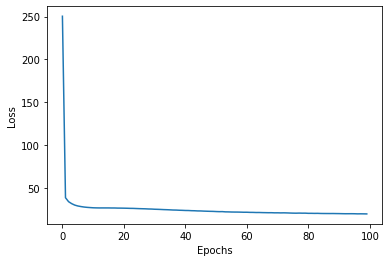

In [37]:
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avgs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [42]:
import os

filename =  "/VAE_First"

import urllib
if not os.path.isdir('./Trained Models'):
    os.makedirs('./Trained Models')
print('downloading ...')

model.load_state_dict(torch.load('./Trained Models'+filename))
print('done')


downloading ...
done


In [43]:
test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [44]:
# set to evaluation mode
model.eval()

test_loss_avgs, num_batches = 0, 0

for batch_idx, (data, labels) in enumerate(test_dataloader):
    
    with torch.no_grad():
    
        data = data.to(device)

        # reconstruction error
        loss = model.forward(data)

        test_loss_avgs += loss.item()
        num_batches += 1
    
test_loss_avgs /= num_batches
print('average loss: %f' % (test_loss_avgs))

average loss: 32.670988
